# TODO 
* speed up bigfish processing
    * write script to spawn multiple sessions on m1
    * work out how to move files between local machine and colab  
* parse .npz files


# Login to OMERO

In [156]:
import omero
from omero.gateway import BlitzGateway
import os
import getpass
import threading
import time

%matplotlib inline 

# setup OMERO connection
PASS = getpass.getpass("Enter Password:")
conn = BlitzGateway('bioc1301', PASS,
        port=4064, group='COVID-19 smFISH', host='omero1.bioch.ox.ac.uk') #davisgroup
conn.connect()
conn.SERVICE_OPTS.setOmeroGroup(-1)

# helper function to display OMERO objects
def print_obj(obj, indent=0):
    print ("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

# keep connection to OMERO alive
def keep_connection_alive():
    while True:
        conn.keepAlive()
        time.sleep(60)

th_ka = threading.Thread(target = keep_connection_alive)
th_ka.daemon = True
th_ka.start()

Enter Password: ········


# Detect spots in both channels and segment

In [165]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import numpy as np
import tifffile
from cellpose import models, io
from skimage.morphology import white_tophat, black_tophat, disk
import time

print("Big-FISH version: {0}".format(bigfish.__version__))

# hard-code the output directory
path_output = "detections/CoV2smFISH/CoV-FISH-10_B117_TIF_RAW"

# get acquisition parameters
def img_params(file_name):
    if 'R1' in file_name:
        voxel_size_z = 200
        voxel_size_yx = 65
        return voxel_size_z, voxel_size_yx
    else:
        voxel_size_z = 200
        voxel_size_yx = 110
        return voxel_size_z, voxel_size_yx        
#psf_z = 350
#psf_yx = 150

# calculate psf (thank you MK), with edit for consistent nomenclature 
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
        #original matlab code commented below:
        #widefield:
        #sigma_xy = 0.225 * lambda_em / NA ;
        #sigma_z  = 0.78 * RI * lambda_em / (NA*NA) ;
        #confocal/nipkow
        #sigma_xy = 0.225 / NA * lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
        #sigma_z =  0.78 * RI / (NA^2) *  lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

# convert OMERO Image object into np array
def get_z_stack(img, c, t=0):
    z_range = range(0, img.getSizeZ(), 1)
    zct_list = [(z, c, t) for z in z_range]
    pixels = img.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))
        
# analyze all images in a dataset
dataset_id = '25066'

def data_assessment(ch, chan):
    for image in conn.getObject('Dataset', dataset_id).listChildren():
        print ('processing ', image.getId())
        img = conn.getObject('Image', image.getId())
        rna = get_z_stack(img, ch)
        # subtract background 
        def subtract_background(image, radius=5, light_bg=False):
            str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
            if light_bg:
                return black_tophat(image, str_el)
            else:
                return white_tophat(image, str_el)
        start_time = time.time()
        rna_no_bg = []
        for z in rna:
            z_no_bg = subtract_background(z)
            rna_no_bg.append(z_no_bg)
        rna = np.array(rna_no_bg)
        print ("background subtraction took ", time.time() - start_time, "sec")
        
data_assessment(2, 'ch3')    
# working code to process images
''' 
    start_time = time.time()   
    print ('processing ', image.getId())
    for orig_file in image.getImportedImageFiles():
        file_name = orig_file.getName()
    if '24h' in file_name:
        print ('skiping', file_name)
        pass
    else:
        img = conn.getObject('Image', image.getId())

        # segment with cellpose
        if 'R1' in file_name:
            seg_img = np.max(get_z_stack(img,2),0)
            seg_img = np.clip(seg_img,0,200)
        else:
            seg_img = np.max(get_z_stack(img,1),0)
        model = models.Cellpose(gpu=False, model_type='cyto')
        channels = [0,0]
        masks, flows, styles, diams = model.eval(seg_img, channels=channels, diameter=375, do_3D=False)

        def detect_spots(chan, ch):
            rna = get_z_stack(img, chan)

            # subtract background 
            def subtract_background(image, radius=5, light_bg=False):
                str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
                if light_bg:
                    return black_tophat(image, str_el)
                else:
                    return white_tophat(image, str_el)

            rna_no_bg = []
            for z in rna:
                z_no_bg = subtract_background(z)
                rna_no_bg.append(z_no_bg)
            rna = np.array(rna_no_bg)

            # calculate_psf(voxel_size_z, voxel_size_yx, 570, 610, 1.4, 1.364, 'confocal')[0]
            psf_z = calculate_psf(img_params(file_name)[0], img_params(file_name)[1], 
                                  570, 610, 1.4, 1.364, 'confocal')[0]
            psf_yx = calculate_psf(img_params(file_name)[0], img_params(file_name)[1], 
                                  570, 610, 1.4, 1.364, 'confocal')[1]
            sigma_z, sigma_yx, sigma_yx = detection.get_sigma(img_params(file_name)[0], 
                                            img_params(file_name)[1], psf_z, psf_yx)            
            sigma = (sigma_z, sigma_yx, sigma_yx)

            # LoG filter
            rna_log = stack.log_filter(rna, sigma)

            # local maximum detection
            mask = detection.local_maximum_detection(rna_log, min_distance=sigma)

            # thresholding
            if 'R1' in file_name:
                #threshold = detection.automated_threshold_setting(rna_log, mask)
                threshold = 100
            else:
                threshold = 30
            spots, _ = detection.spots_thresholding(rna_log, mask, threshold)

            # detect and decompose clusters
            spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
            rna, spots, 
            img_params(file_name)[0], img_params(file_name)[1], psf_z, psf_yx,
            alpha=0.7,  # alpha impacts the number of spots per cluster
            beta=1)   # beta impacts the number of detected clusters

            # separate spots from clusters
            radius = 350
            nb_min_spots = 4
            spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition, 
                img_params(file_name)[0], img_params(file_name)[1], radius, nb_min_spots)

            # extract cell level results
            image_contrasted = stack.rescale(rna, channel_to_stretch=0)
            image_contrasted = stack.maximum_projection(image_contrasted)
            rna_mip = stack.maximum_projection(rna)

            fov_results = stack.extract_cell(
                cell_label=masks.astype(np.int64),
                ndim=3, 
                rna_coord=spots_post_clustering, 
                others_coord={"foci": foci},
                image=image_contrasted,
                others_image={"smfish": rna_mip})

            # save results
            for i, cell_results in enumerate(fov_results):
                path = os.path.join(path_output, file_name.split('.')[0]+'_'+ch+'_results_cell_{0}.npz'.format(i))
                stack.save_cell_extracted(cell_results, path)
                
        detect_spots(2, 'ch3')
        detect_spots(3, 'ch4')
        print ("bigfish analysis took ", time.time() - start_time, "sec")
'''
print ('FINISHED!')


Big-FISH version: 0.4.0
background subtraction took  5.46619987487793 sec


KeyboardInterrupt: 

In [177]:
file_name = 'CoV-FISH-10_Vero_2h_B117_INF_R3_00010.tif'
img = tifffile.imread(file_name)
rna = np.swapaxes(img,0,1)[2]
rna.shape
print(np.mean(rna))

# subtract background 
def subtract_background(image, radius=5, light_bg=False):
    str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)
rna_no_bg = []
for z in rna:
    z_no_bg = subtract_background(z)
    rna_no_bg.append(z_no_bg)
rna = np.array(rna_no_bg)
print(np.mean(rna))

117.79698199233717
10.6391720545977


# Run bigfish on a local file

In [144]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import numpy as np
import tifffile
from cellpose import models, io
from skimage.morphology import white_tophat, black_tophat, disk
import time

print("Big-FISH version: {0}".format(bigfish.__version__))

# hard-code the input/output directories
indir = os.getcwd()
infiles = [x for x in os.listdir(indir) if x.endswith('.tif')]
path_output = os.path.join(indir,'detections')
file_name = 'CoV-FISH-10_Vero_2h_B117_INF_R3_00010.tif'
# get acquisition parameters
def img_params(file_name):
    if 'R1' in file_name:
        voxel_size_z = 200
        voxel_size_yx = 65
        return voxel_size_z, voxel_size_yx
    else:
        voxel_size_z = 200
        voxel_size_yx = 110
        return voxel_size_z, voxel_size_yx        
#psf_z = 350
#psf_yx = 150

# calculate psf (thank you MK), with edit for consistent nomenclature 
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
        #original matlab code commented below:
        #widefield:
        #sigma_xy = 0.225 * lambda_em / NA ;
        #sigma_z  = 0.78 * RI * lambda_em / (NA*NA) ;
        #confocal/nipkow
        #sigma_xy = 0.225 / NA * lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
        #sigma_z =  0.78 * RI / (NA^2) *  lambda_ex * lambda_em / sqrt( lambda_ex^2 + lambda_em^2 ) ;
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

# convert OMERO Image object into np array
def get_z_stack(img, c, t=0):
    z_range = range(0, img.getSizeZ(), 1)
    zct_list = [(z, c, t) for z in z_range]
    pixels = img.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))
        
# analyze all images in a dataset
start_time = time.time()
print ('processing ', file_name)
img = tifffile.imread(os.path.join(indir,file_name))
print ("file loading took ", time.time() - start_time, "sec")

# segment with cellpose
if 'R1' in file_name:
    seg_img = np.max(img[:,2],0)
    seg_img = np.clip(seg_img,0,200)
else:
    seg_img = np.max(img[:,1],0)
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0]
masks, flows, styles, diams = model.eval(seg_img, channels=channels, diameter=375, do_3D=False)

def detect_spots(chan, ch):
    rna = np.swapaxes(img,0,1)[chan]

    # subtract background 
    def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

    rna_no_bg = []
    for z in rna:
        z_no_bg = subtract_background(z)
        rna_no_bg.append(z_no_bg)
    rna = np.array(rna_no_bg)

    # calculate_psf(voxel_size_z, voxel_size_yx, 570, 610, 1.4, 1.364, 'confocal')[0]
    psf_z = calculate_psf(img_params(file_name)[0], img_params(file_name)[1], 
                          570, 610, 1.4, 1.364, 'confocal')[0]
    psf_yx = calculate_psf(img_params(file_name)[0], img_params(file_name)[1], 
                          570, 610, 1.4, 1.364, 'confocal')[1]
    sigma_z, sigma_yx, sigma_yx = detection.get_sigma(img_params(file_name)[0], 
                                    img_params(file_name)[1], psf_z, psf_yx)            
    sigma = (sigma_z, sigma_yx, sigma_yx)

    # LoG filter
    rna_log = stack.log_filter(rna, sigma)

    # local maximum detection
    mask = detection.local_maximum_detection(rna_log, min_distance=sigma)
    
    threshold = 200
    #threshold = detection.automated_threshold_setting(rna_log, mask)
    spots, _ = detection.spots_thresholding(rna_log, mask, threshold)

    # detect and decompose clusters
    spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
    rna, spots, 
    img_params(file_name)[0], img_params(file_name)[1], psf_z, psf_yx,
    alpha=0.7,  # alpha impacts the number of spots per cluster
    beta=1)   # beta impacts the number of detected clusters

    # separate spots from clusters
    radius = 350
    nb_min_spots = 4
    spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition, 
        img_params(file_name)[0], img_params(file_name)[1], radius, nb_min_spots)

    # extract cell level results
    image_contrasted = stack.rescale(rna, channel_to_stretch=0)
    image_contrasted = stack.maximum_projection(image_contrasted)
    rna_mip = stack.maximum_projection(rna)

    fov_results = stack.extract_cell(
        cell_label=masks.astype(np.int64),
        ndim=3, 
        rna_coord=spots_post_clustering, 
        others_coord={"foci": foci},
        image=image_contrasted,
        others_image={"smfish": rna_mip})

    # save results
    for i, cell_results in enumerate(fov_results):
        path = os.path.join(path_output, file_name.split('.')[0]+'_'+ch+'_results_cell_{0}.npz'.format(i))
        stack.save_cell_extracted(cell_results, path)
    print ("bigfish analysis took ", time.time() - start_time, "sec")

detect_spots(2, 'ch3')
detect_spots(3, 'ch4')


print ('FINISHED!')


Big-FISH version: 0.4.0
processing  CoV-FISH-10_Vero_2h_B117_INF_R3_00010.tif
file loading took  0.34070706367492676 sec
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 1.94s; flow+mask computation 0.54
estimated masks for 1 image(s) in 2.55 sec
>>>> TOTAL TIME 2.55 sec
bigfish analysis took  24.23088002204895 sec
bigfish analysis took  45.01264691352844 sec
FINISHED!


>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 3.24s; flow+mask computation 1.28
estimated masks for 1 image(s) in 4.72 sec
>>>> TOTAL TIME 4.72 sec


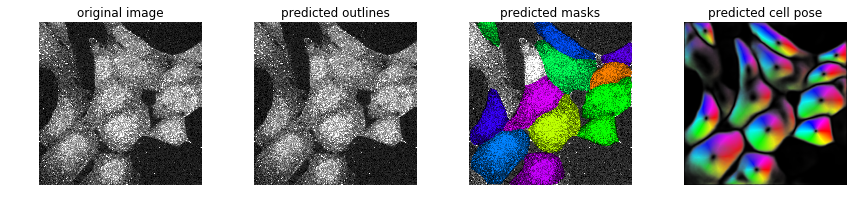

In [139]:
# RUN CELLPOSE

from cellpose import models, io, plot
import matplotlib.pyplot as plt
import skimage.io
from datetime import datetime

# R1 settings
#file_name = 'CoV-FISH-10_Vero_2h_B117_INF_R1_00001.tif'
seg_img = np.max(img[:,2],0)
seg_img = np.clip(seg_img,0,200)

# R2/3 settings (no bg subtraction)
model = models.Cellpose(gpu=False, model_type='cyto')
#seg_img = np.max(img[:,1],0)
channels = [0,0]
masks, flows, styles, diams = model.eval(seg_img, channels=channels, diameter=375, do_3D=False)

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, seg_img, masks, flows[0], channels)
plt.tight_layout()
plt.show()

In [139]:
# extract cell level results
image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)

fov_results = stack.extract_cell(
    cell_label=masks.astype(np.int64),
    ndim=3, 
    rna_coord=spots_post_clustering, 
    others_coord={"foci": foci},
    image=image_contrasted,
    others_image={"smfish": rna_mip})
print("number of cells identified: {0}".format(len(fov_results)))

NameError: name 'rna' is not defined

In [188]:
dataset_id = '25066'

# make a list of all files in directory
omero_dir = {}
for image in conn.getObject('Dataset', dataset_id).listChildren():
    for orig_file in image.getImportedImageFiles():
        #omero_dir.append(orig_file.getName())
        omero_dir[orig_file.getName()] = conn.getObject('Image', image.getId())

KeyboardInterrupt: 

In [189]:
omero_dir

{'CoV-FISH-10_Vero_24h_MOCK_R2_00001.tif': <_ImageWrapper id=972273>,
 'CoV-FISH-10_Vero_24h_MOCK_R2_00002.tif': <_ImageWrapper id=972655>,
 'CoV-FISH-10_Vero_24h_MOCK_R2_00003.tif': <_ImageWrapper id=972667>,
 'CoV-FISH-10_Vero_24h_MOCK_R2_00004.tif': <_ImageWrapper id=972455>,
 'CoV-FISH-10_Vero_24h_MOCK_R2_00005.tif': <_ImageWrapper id=972535>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00001.tif': <_ImageWrapper id=972462>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00002.tif': <_ImageWrapper id=972549>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00003.tif': <_ImageWrapper id=972311>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00004.tif': <_ImageWrapper id=972402>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00005.tif': <_ImageWrapper id=972185>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00006.tif': <_ImageWrapper id=972279>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00007.tif': <_ImageWrapper id=972641>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00008.tif': <_ImageWrapper id=972600>,
 'CoV-FISH-10_Vero_24h_Vic_INF_R2_00009.tif': <_ImageWrapper id=97

In [127]:
import bigfish.plot as plot
for i, cell_results in enumerate(fov_results):
    print("cell {0}".format(i))
    
    # get cell results
    cell_mask = cell_results["cell_mask"]
    cell_coord = cell_results["cell_coord"]
    rna_coord = cell_results["rna_coord"]
    foci_coord = cell_results["foci"]
    image_contrasted = cell_results["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))
    
    # plot cell
    if i == 0:
        path = "../images/plot_cell.png"
    else:
        path = None
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, rna_coord=rna_coord, 
        foci_coord=foci_coord, image=image_contrasted, 
        cell_mask=cell_mask, 
        title="Cell {0}".format(i), framesize=(12, 10))

NameError: name 'fov_results' is not defined

In [125]:
df = stack.summarize_extraction_results(fov_results, ndim=3)
print("shape: {0}".format(df.shape))
df.head()

shape: (6, 5)


cell_id  nb_rna  nb_rna_in_nuc  nb_rna_out_nuc  nb_foci
0        4     218            NaN             NaN        2
1        6     275            NaN             NaN       12
2        8     132            NaN             NaN        4
3        9     514            NaN             NaN       24
4       10     145            NaN             NaN        5

# Save results in npz file

In [149]:
for i, cell_results in enumerate(fov_results):
    # save results
    path = os.path.join(path_output, file_name.split('.')[0]+'_results_cell_{0}.npz'.format(i))
    stack.save_cell_extracted(cell_results, path)

In [127]:
path_output = 'detections/CoV2smFISH/CoV-FISH-10_B117_TIF_RAW/'

In [147]:
file_name.split('.')[0]

'CoV-FISH-10_Vero_2h_B117_INF_R1_00001'

# Read npz files

In [143]:
# load single cell data
path = os.path.join(path_output, "results_cell_0.npz")
data = stack.read_cell_extracted(path, verbose=True)

rna_coord = data["rna_coord"]
print("RNAs coordinates")
print("\r shape: {0}".format(rna_coord.shape))
print("\r dtype: {0}".format(rna_coord.dtype))

foci_coord = data["foci"]
print("foci coordinates")
print("\r shape: {0}".format(foci_coord.shape))
print("\r dtype: {0}".format(foci_coord.dtype))

Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

RNAs coordinates
 shape: (218, 4)
 dtype: int64
foci coordinates
 shape: (2, 5)
 dtype: int64


# Show cell level results

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_results_cell_4.npz
 number of rna 1
 number of foci 0


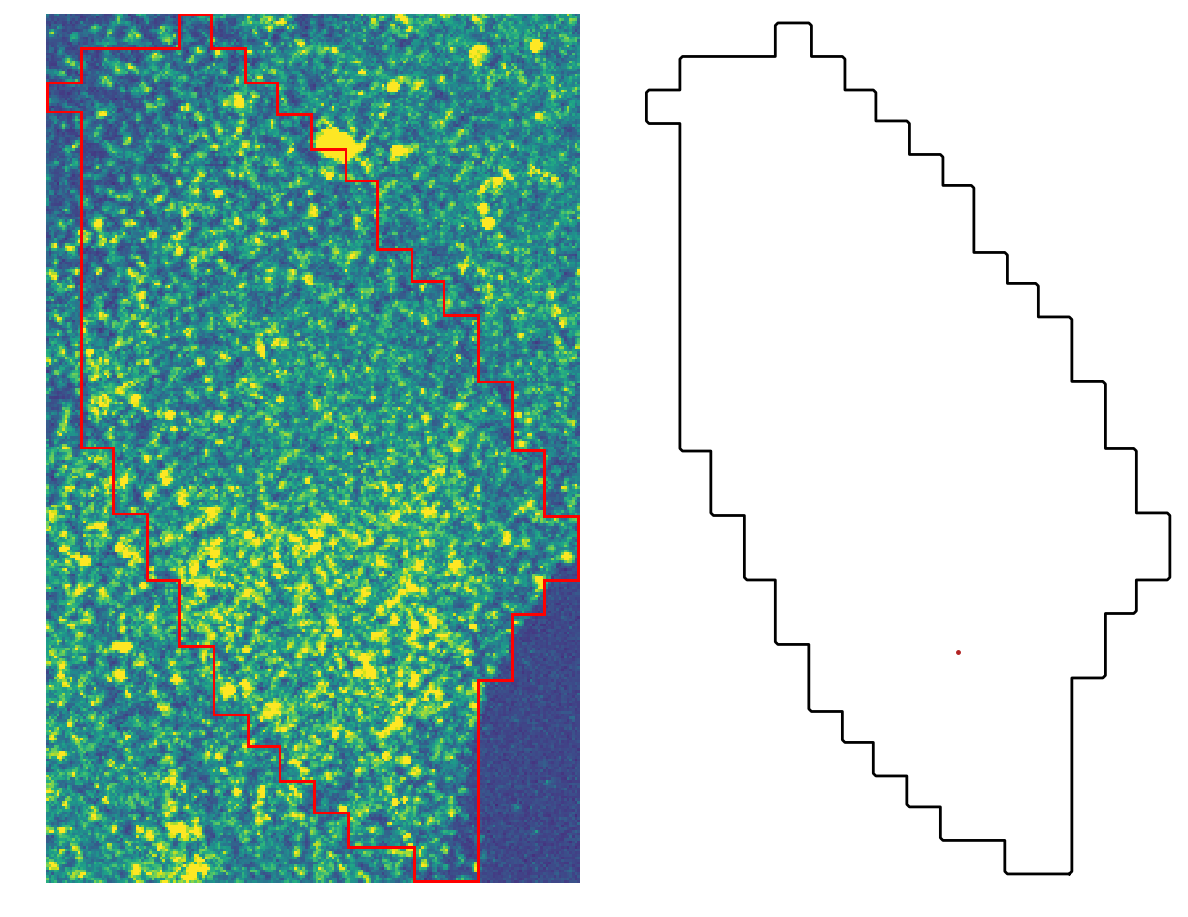

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_results_cell_2.npz
 number of rna 1
 number of foci 0


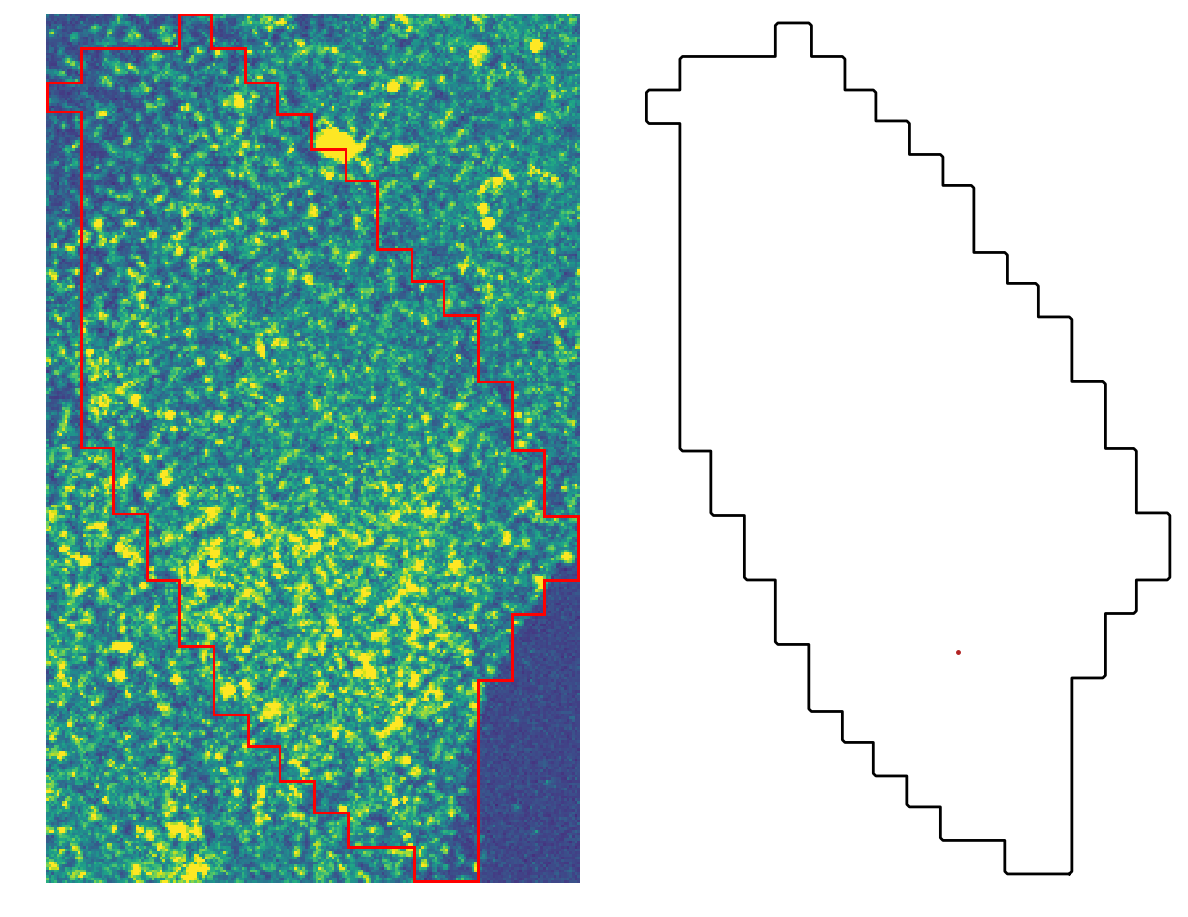

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_results_cell_3.npz
 number of rna 1
 number of foci 0


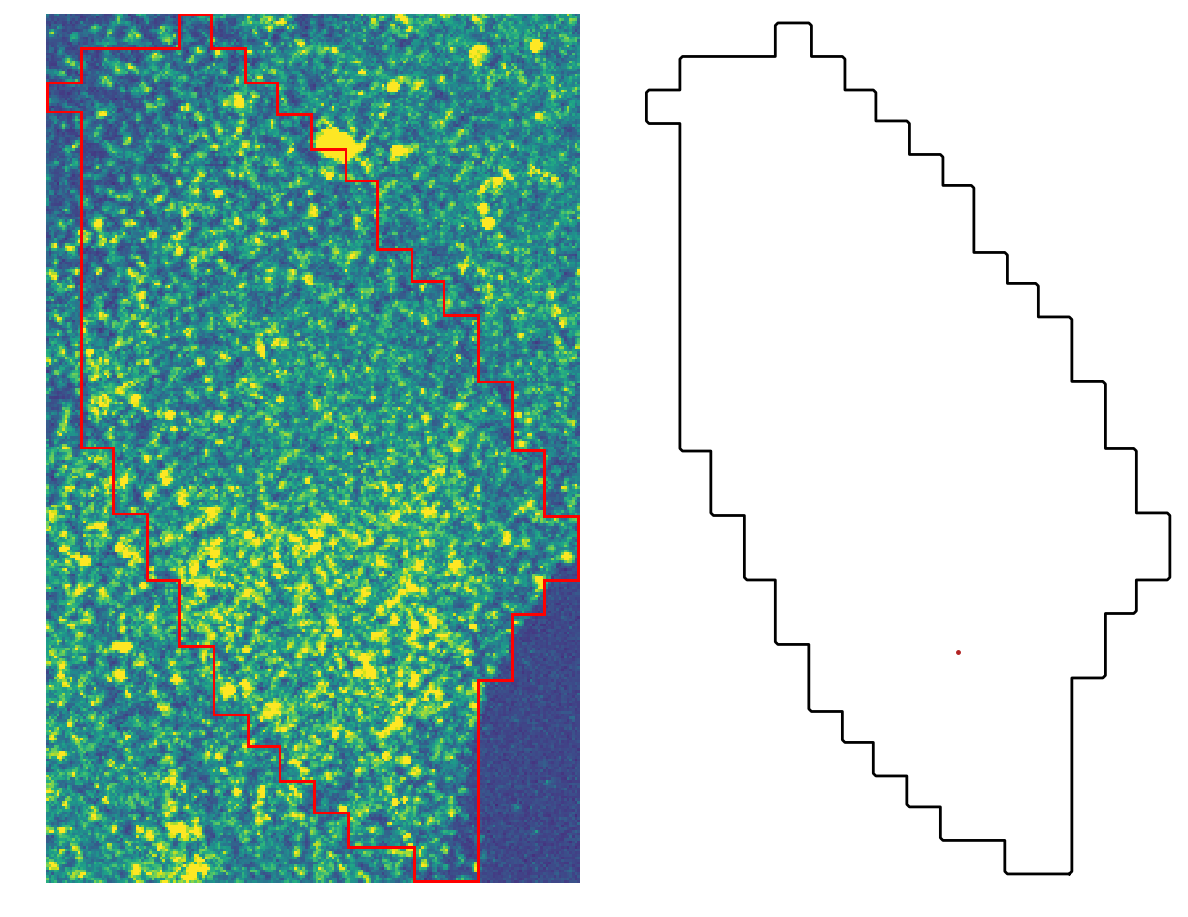

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_results_cell_1.npz
 number of rna 1
 number of foci 0


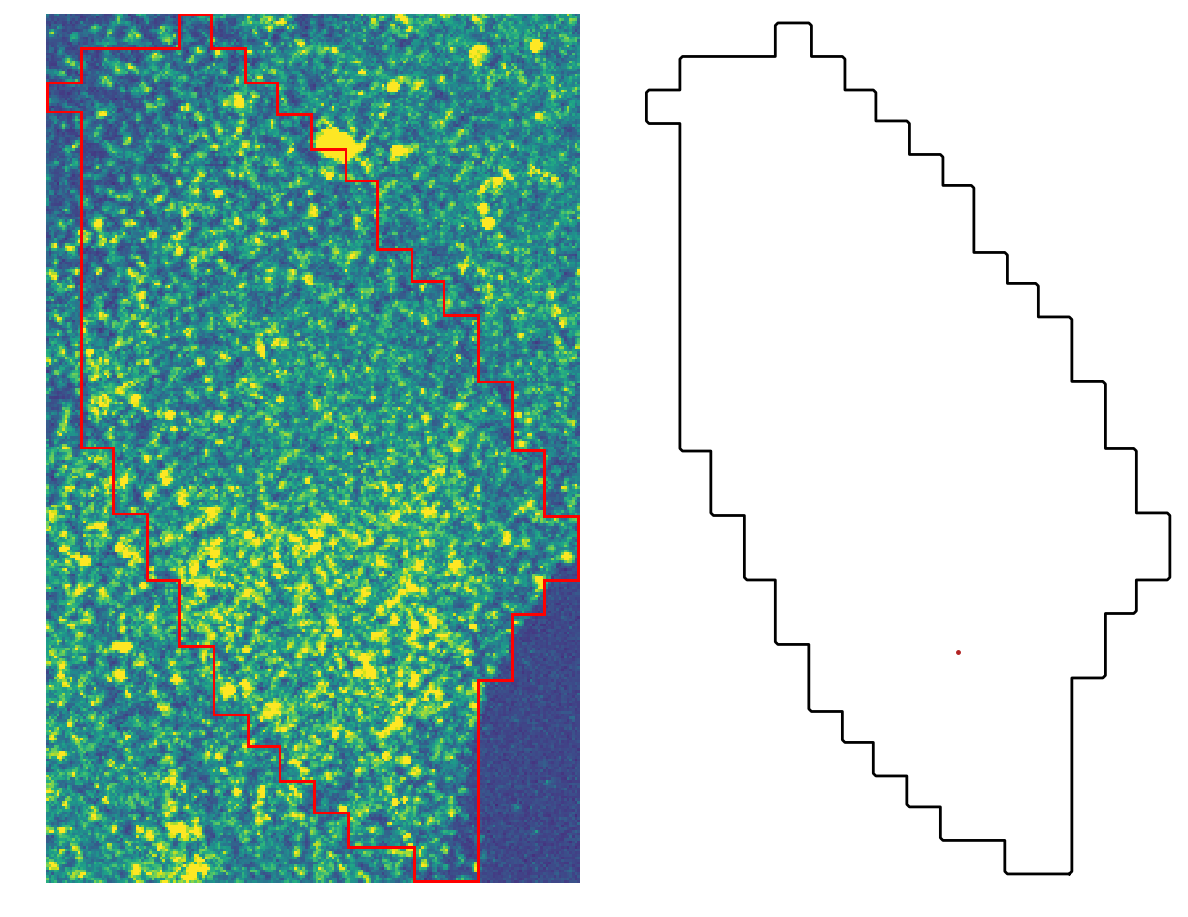

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_results_cell_0.npz
 number of rna 1
 number of foci 0


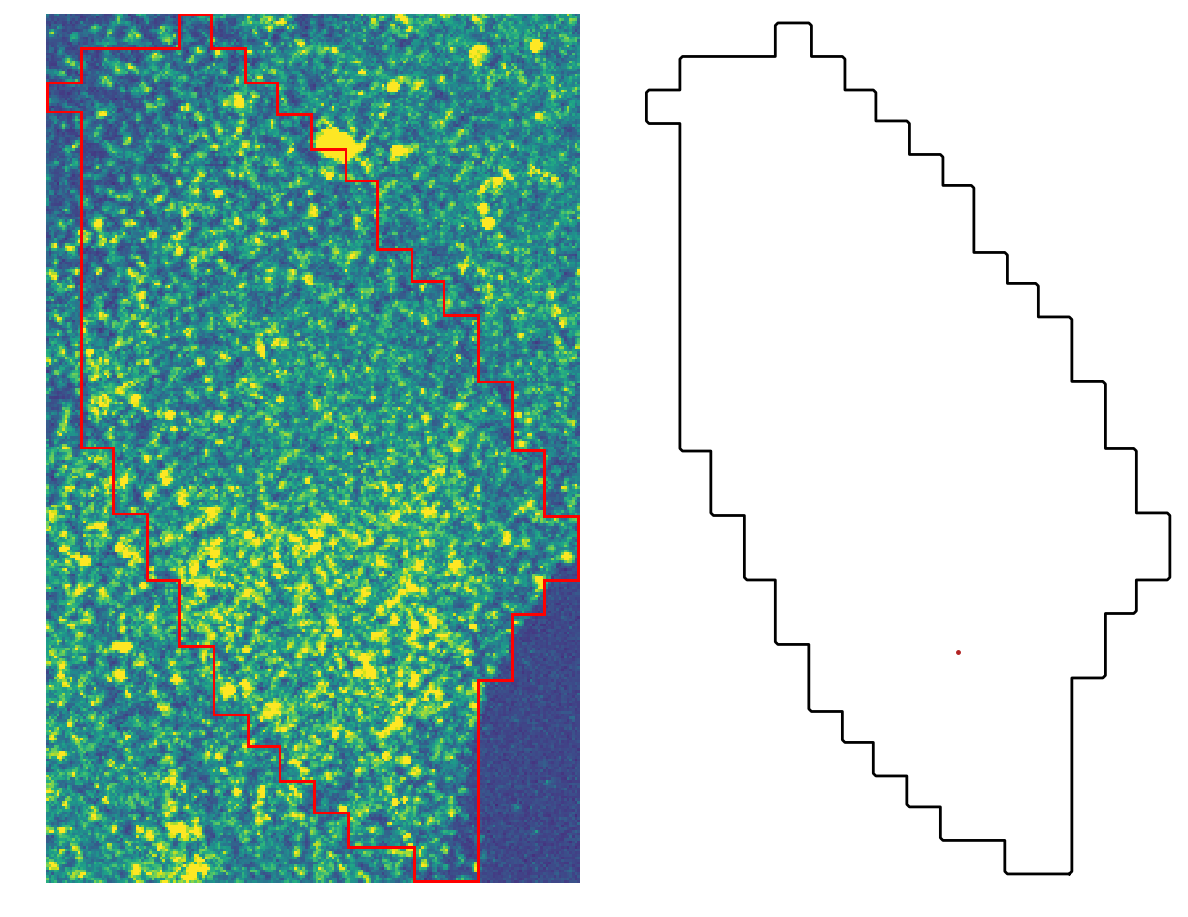

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch4_results_cell_4.npz
 number of rna 1
 number of foci 0


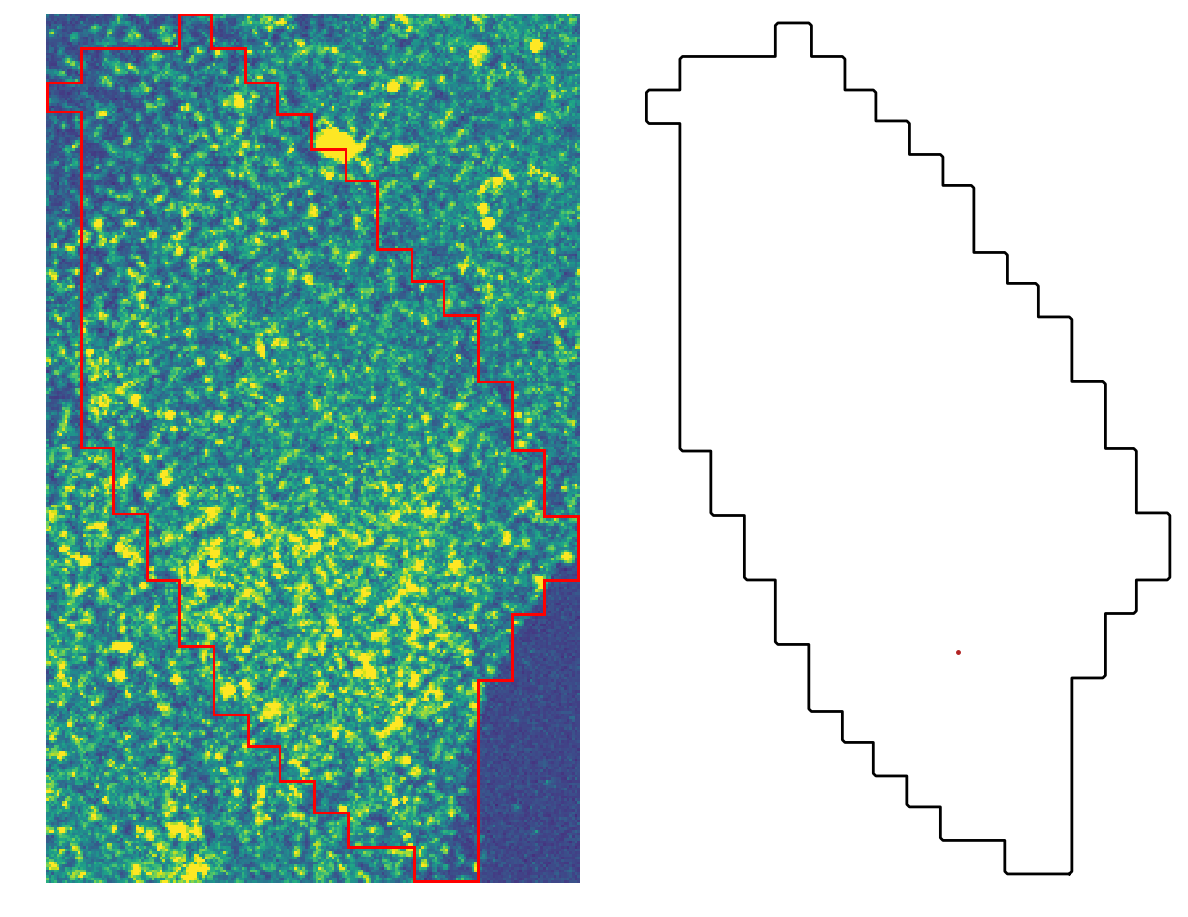

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch4_results_cell_0.npz
 number of rna 1
 number of foci 0


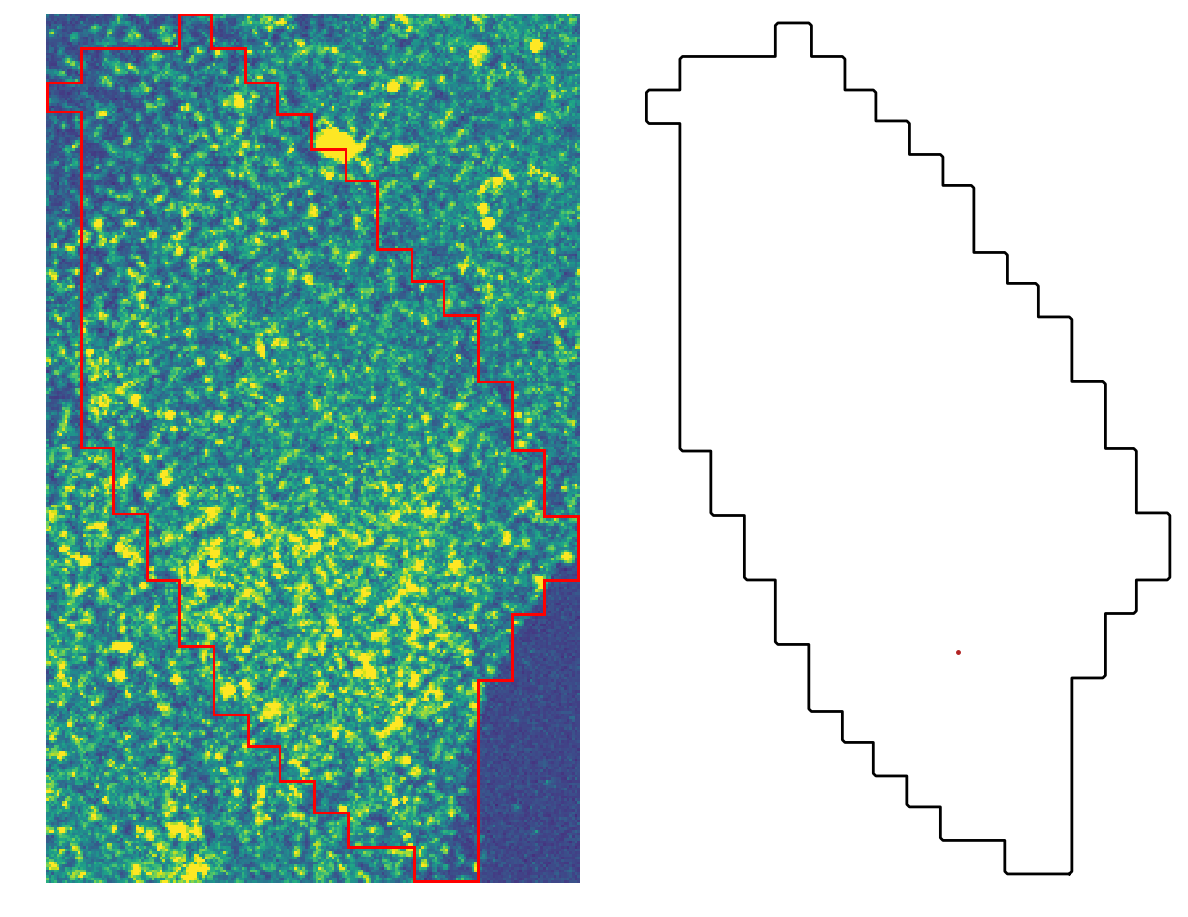

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch4_results_cell_1.npz
 number of rna 1
 number of foci 0


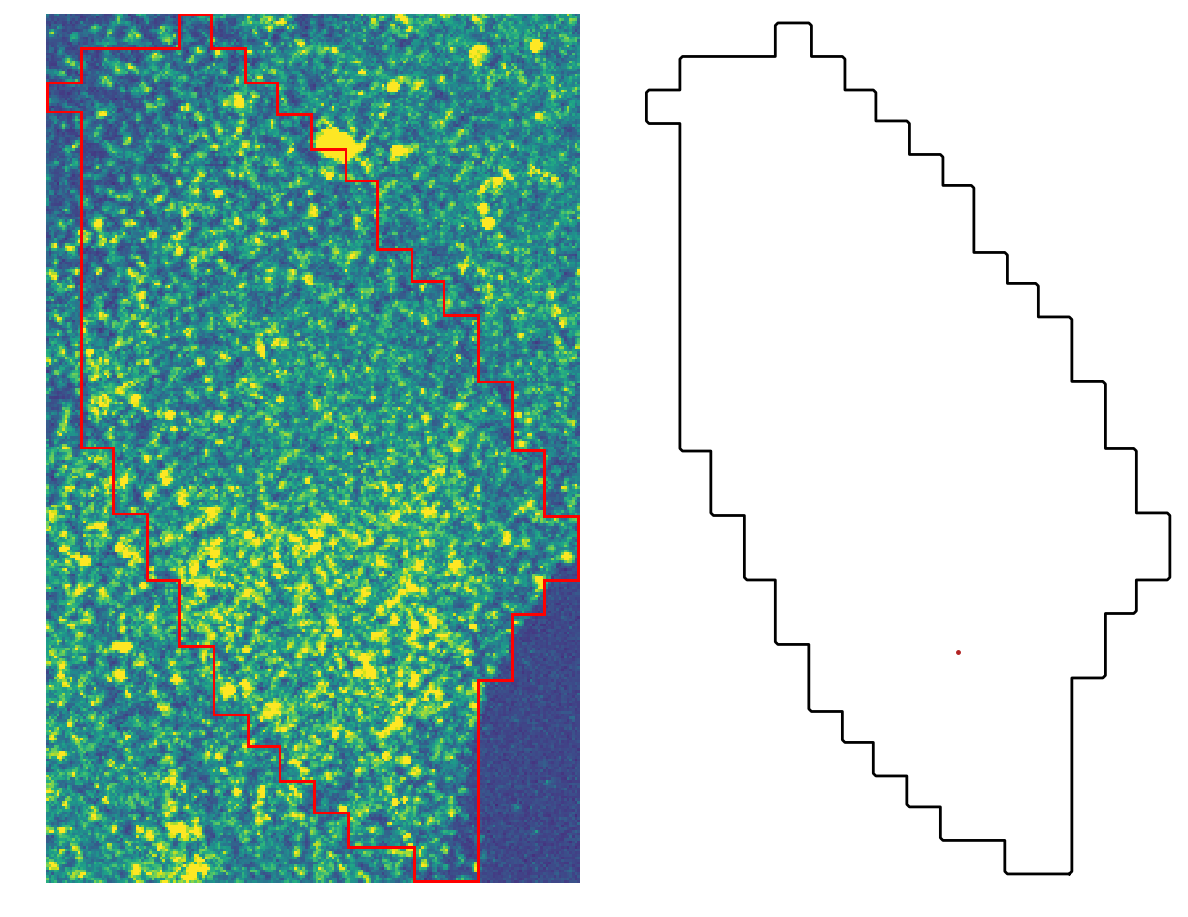

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch4_results_cell_3.npz
 number of rna 1
 number of foci 0


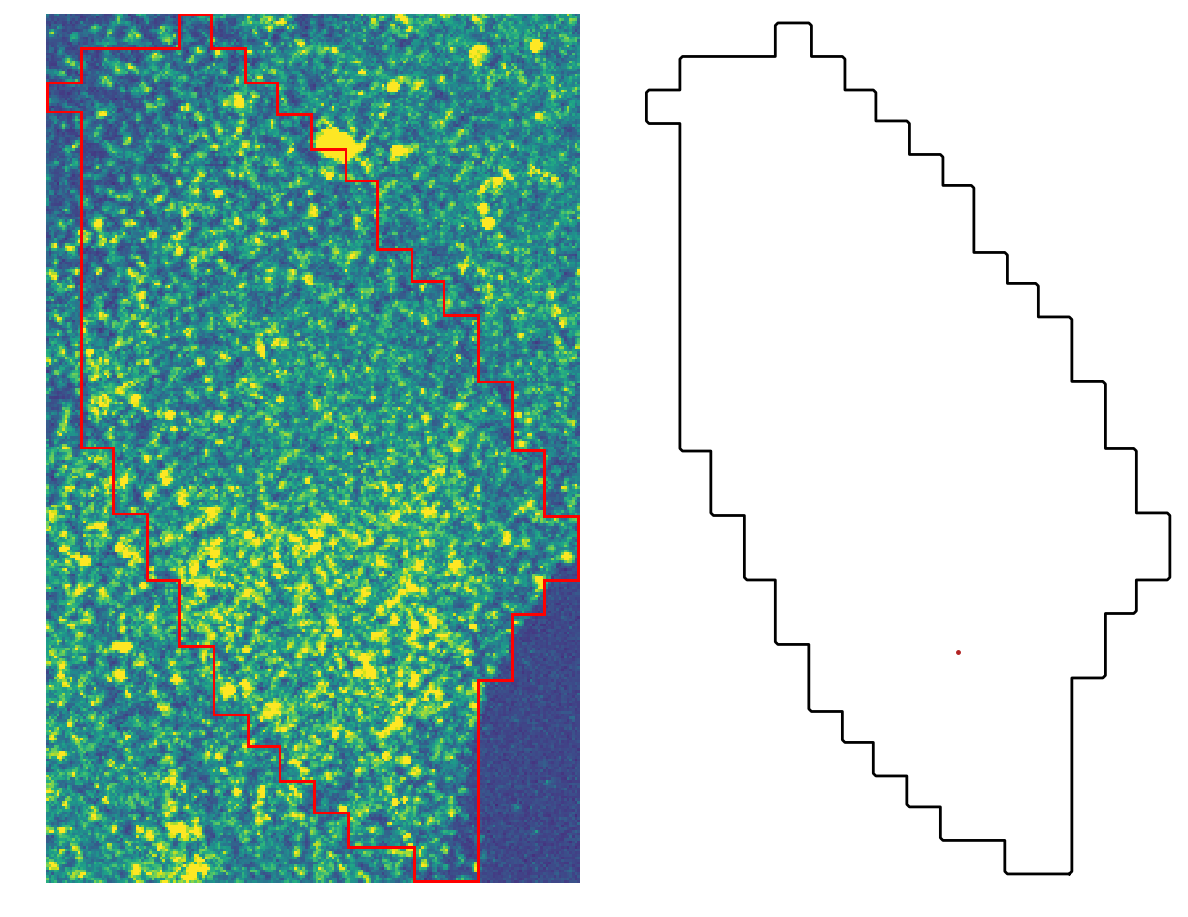

CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch4_results_cell_2.npz
 number of rna 1
 number of foci 0


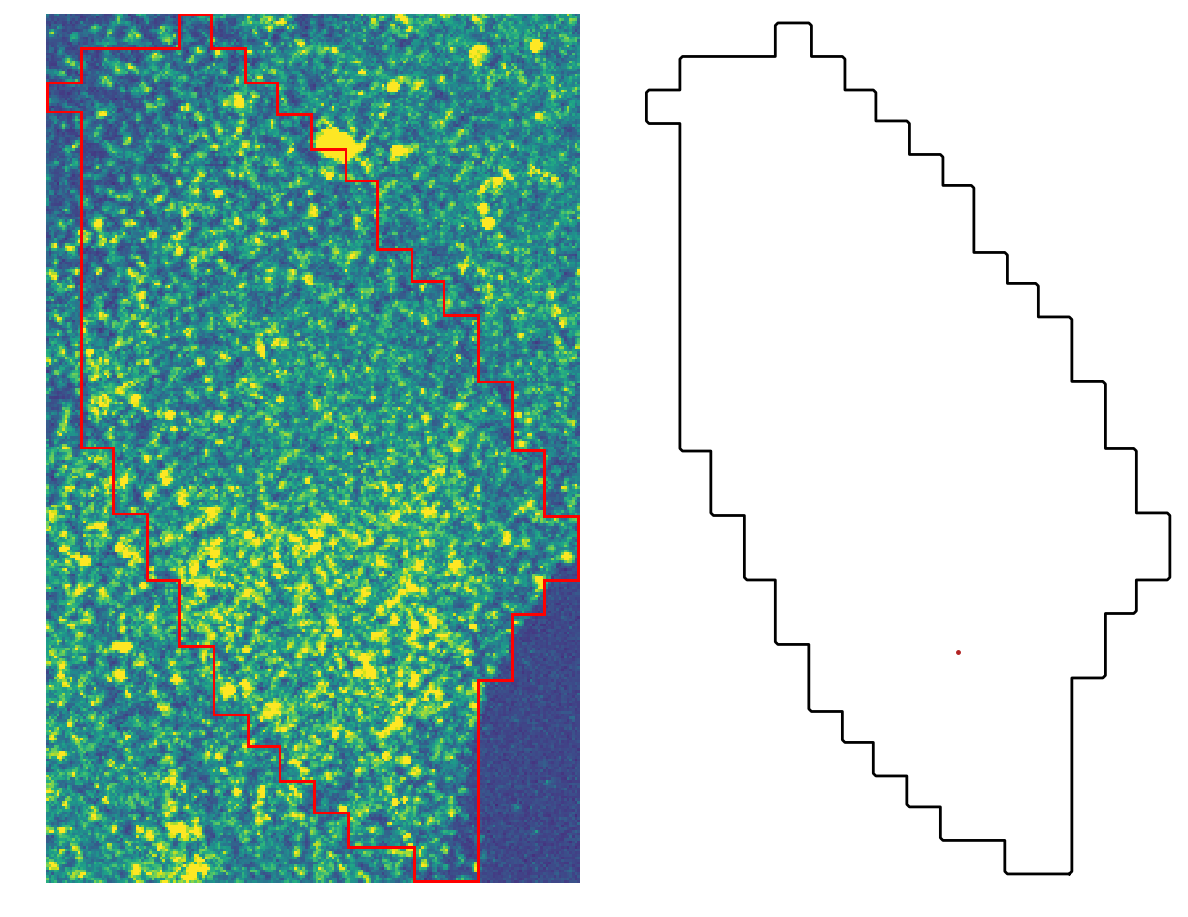

In [152]:
# load single cell data
indir = 'detections'
infiles = [x for x in os.listdir(indir) if x.endswith('.npz')]
def plot_cells():
    # get cell results
    cell_mask = data["cell_mask"]
    cell_coord = data["cell_coord"]
    rna_coord = data["rna_coord"]
    foci_coord = data["foci"]
    image_contrasted = data["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))

    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, rna_coord=rna_coord, 
        foci_coord=foci_coord, image=image_contrasted, 
        cell_mask=cell_mask, framesize=(12, 10))
    
for file in infiles:
    np.load(os.path.join(indir, file))
    print (file)
    plot_cells()


In [135]:
path
CoV-FISH-10_Vero_2h_B117_INF_R3_00010.tif

'detections/CoV2smFISH/CoV-FISH-10_B117_TIF_RAW/CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_results_cell_4.npz'

# Analysis

In [114]:
import numpy as np
import pandas as pd

# build a dataframe from .npz files
indir = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV_spatial_randomness/CoV-FISH-10_B117_TIF_RAW/detections'
infiles = [x for x in os.listdir(indir) if x.endswith('.npz')]

# prepare buckets for the data
file_name = []
ch = []
strain = []
time = []
treatment = []
total_vRNAs = []
cytosolic_RNAs = []
repSites = []
mol_per_repSite = []
    
# parse .npz files
conditions = ['2h_B117_RDV', '2h_MOCK', '2h_Vic_INF', '2h_Vic_RDV']
for file in infiles:
    data = np.load(os.path.join(indir, file))
    file_name.append(file)
    total_vRNAs.append(data['rna_coord'].shape[0]+np.sum(data['foci'][:,4]))
    cytosolic_RNAs.append(data['rna_coord'].shape[0])
    repSites.append(data['foci'].shape[0])
    mol_per_repSite.append(np.mean(data['foci'][:,4]))
    
    if '2h_MOCK' in file:
        strain.append('None')
        time.append(2)
        treatment.append('MOCK')
    if '2h_B117_INF' in file:
        strain.append('B117')
        time.append(2)
        treatment.append('INF')
    if '2h_B117_RDV' in file:
        strain.append('B117')
        time.append(2)
        treatment.append('RDV')
    if '2h_Vic_INF' in file:
        strain.append('Vic')
        time.append(2)
        treatment.append('INF')  
    if '2h_Vic_RDV' in file:
        strain.append('Vic')
        time.append(2)
        treatment.append('RDV')
    if 'ch3' in file:
        ch.append(3)
    if 'ch4' in file:
        ch.append(4)

data_tall = pd.DataFrame(list(zip(file_name, ch, strain, time, treatment, total_vRNAs,
                            cytosolic_RNAs, repSites, mol_per_repSite)),
            columns =['file_name', 'ch', 'strain', 'time', 'treatment', 'total_vRNAs',
                            'cytosolic_RNAs', 'repSites', 'mol_per_repSite'])
data_tall.to_csv('Data_summary.csv')
print('finished')

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finished


In [61]:
data_tall.head(5)

file_name  ch strain  time  \
0  CoV-FISH-10_Vero_2h_B117_INF_R3_00010_ch3_resu...   3   B117     2   
1  CoV-FISH-10_Vero_2h_B117_RDV_R1_00009_ch3_resu...   3   B117     2   
2  CoV-FISH-10_Vero_2h_B117_INF_R2_00001_ch3_resu...   3   B117     2   
3  CoV-FISH-10_Vero_2h_B117_INF_R1_00002_ch3_resu...   3   B117     2   
4  CoV-FISH-10_Vero_2h_B117_INF_R2_00006_ch3_resu...   3   B117     2   

  treatment  total_vRNAs  cytosolic_RNAs  repSites  mol_per_repSite  
0       RDV       475769           11649       261      1778.237548  
1       RDV           72              72         0              NaN  
2       RDV      1156454           13702       521      2193.381958  
3       RDV          137              80         2        28.500000  
4       RDV       238223            7582       124      1860.008065

# Plot the total RNA for both strains

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5,1,'Vero cells 2 hpi thresh = 150')

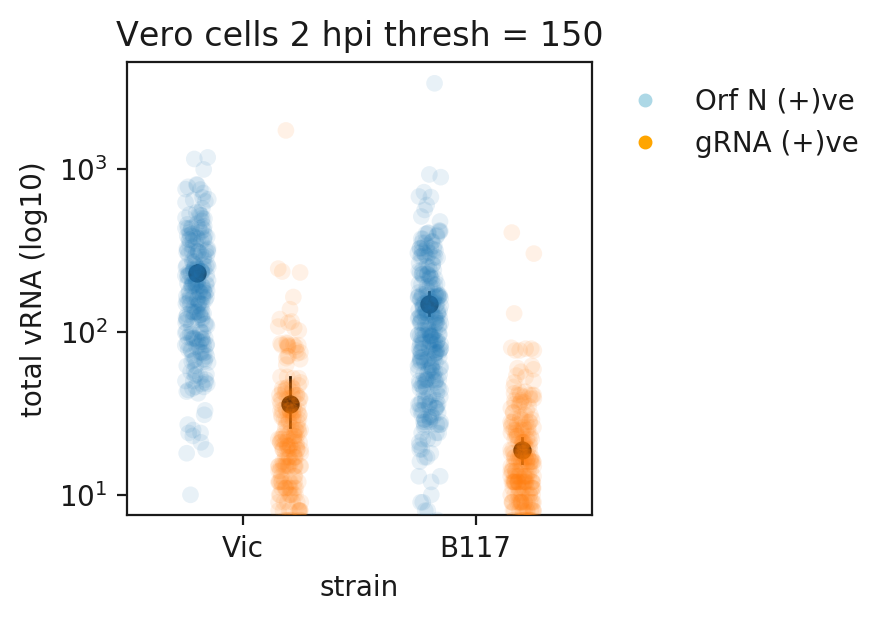

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_2hpi_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF":
        INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='Orf N (+)ve')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='gRNA (+)ve')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(INF_strain, INF_total_vRNAs, size = 6,hue = INF_channel,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(INF_strain, INF_total_vRNAs, size = 4,hue = INF_channel,  
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('total vRNA (log10)')
plt.xlabel('strain')
plt.yscale('log')
plt.minorticks_off()
plt.legend(handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))
plt.title('Vero cells 2 hpi thresh = 150')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5,1,'Vero cells 2 hpi autothresh')

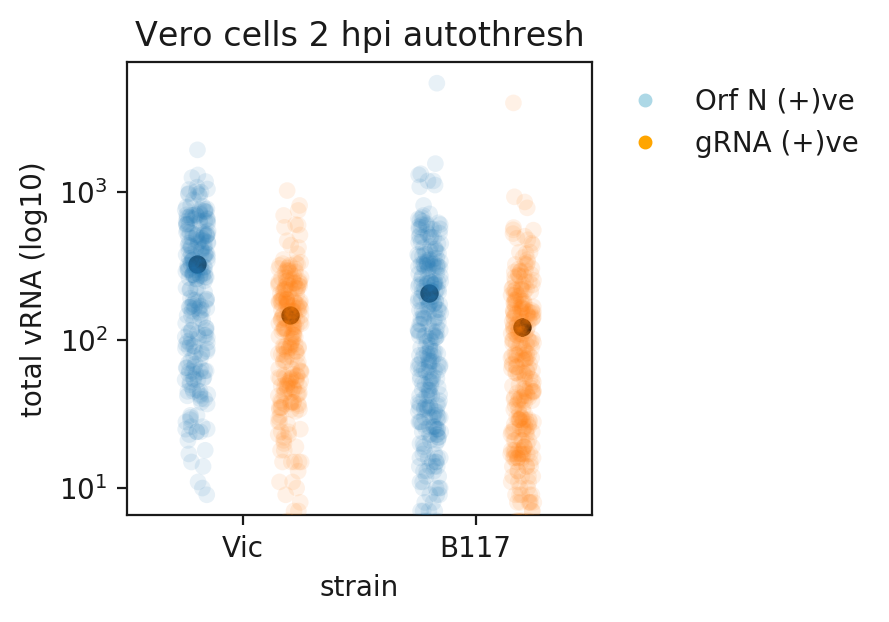

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_2hpi_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF":
        INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='Orf N (+)ve')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='gRNA (+)ve')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(INF_strain, INF_total_vRNAs, size = 6,hue = INF_channel,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(INF_strain, INF_total_vRNAs, size = 4,hue = INF_channel, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('total vRNA (log10)')
plt.xlabel('strain')
plt.yscale('log')
plt.minorticks_off()
plt.legend(handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))
plt.title('Vero cells 2 hpi autothresh')

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5,1,'Vero cells 6 hpi autothresh')

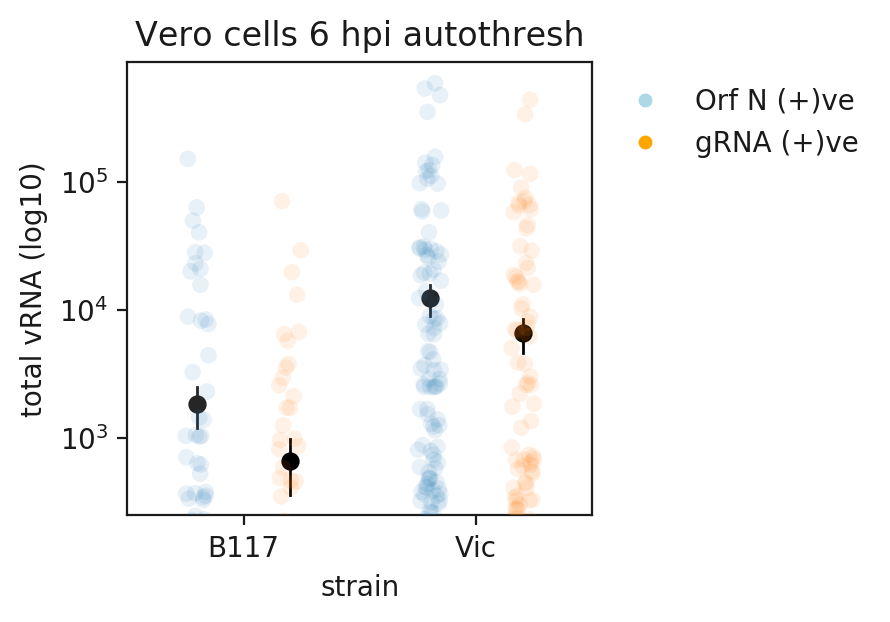

In [322]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_6hpi_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF":
        INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='Orf N (+)ve')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='gRNA (+)ve')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(INF_strain, INF_total_vRNAs, size = 6,hue = INF_channel,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(INF_strain, INF_total_vRNAs, size = 4,hue = INF_channel, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('total vRNA (log10)')
plt.xlabel('strain')
plt.yscale('log')
plt.minorticks_off()
plt.legend(handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))
plt.title('Vero cells 6 hpi autothresh')

In [338]:
data_tall

Unnamed: 0                                          file_name  ch  \
0              0  CoV-FISH-10_Vero_24h_MOCK_R2_00001_ch3_results...   3   
1              1  CoV-FISH-10_Vero_24h_MOCK_R2_00001_ch3_results...   3   
2              2  CoV-FISH-10_Vero_24h_MOCK_R2_00001_ch3_results...   3   
3              3  CoV-FISH-10_Vero_24h_MOCK_R2_00001_ch3_results...   3   
4              4  CoV-FISH-10_Vero_24h_MOCK_R2_00001_ch3_results...   3   
...          ...                                                ...  ..   
5636        5636  CoV-FISH-10_Vero_6h_Vic_RDV_R3_00010_ch4_resul...   4   
5637        5637  CoV-FISH-10_Vero_6h_Vic_RDV_R3_00010_ch4_resul...   4   
5638        5638  CoV-FISH-10_Vero_6h_Vic_RDV_R3_00010_ch4_resul...   4   
5639        5639  CoV-FISH-10_Vero_6h_Vic_RDV_R3_00010_ch4_resul...   4   
5640        5640  CoV-FISH-10_Vero_6h_Vic_RDV_R3_00010_ch4_resul...   4   

     strain  time treatment  total_vRNAs  cytosolic_RNAs  repSites  \
0      None    24      MOCK           27              25         1   
1      None    24      MOCK            0               0         0   
2      None    24      MOCK            6               6         0   
3      None    24      MOCK            5               5         0   
4      None    24      MOCK           12              12         0   
...     ...   ...       ...          ...             ...       ...   
5636    Vic     6       RDV          140             122         3   
5637    Vic     6       RDV           57              57         0   
5638    Vic     6       RDV          110              80         3   
5639    Vic     6       RDV          208             198         3   
5640    Vic     6       RDV           61              61         0   

      mol_per_repSite  
0            2.000000  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
5636         6.000000  
5637              NaN  
5638        10.000000  
5639         3.333333  
5640              NaN  

[5641 rows x 10 columns]

# Infection timecourse by strain (gRNA (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

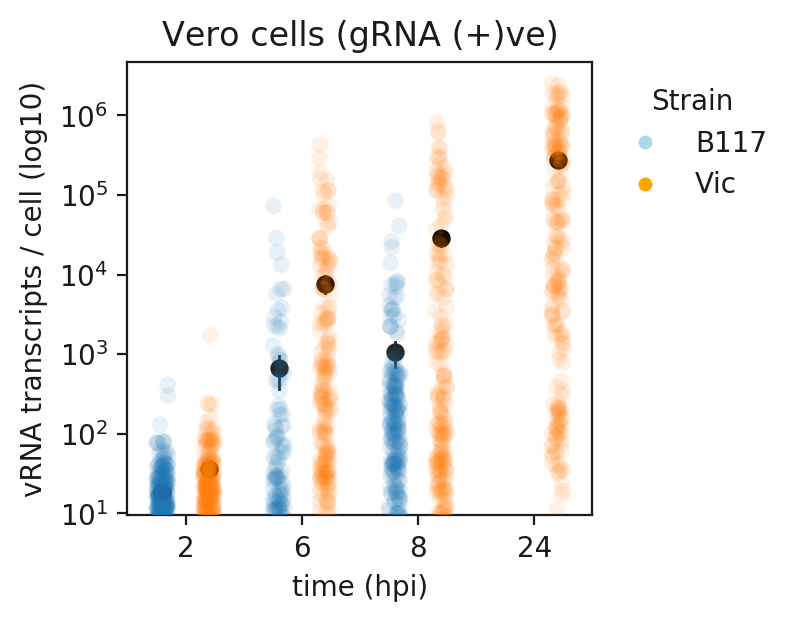

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []
time = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and  row['ch'] == 4:
        #INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Infection timecourse by strain (Orf N (+)ve)

Text(0.5,1,'Vero cells (Orf N (+)ve)')

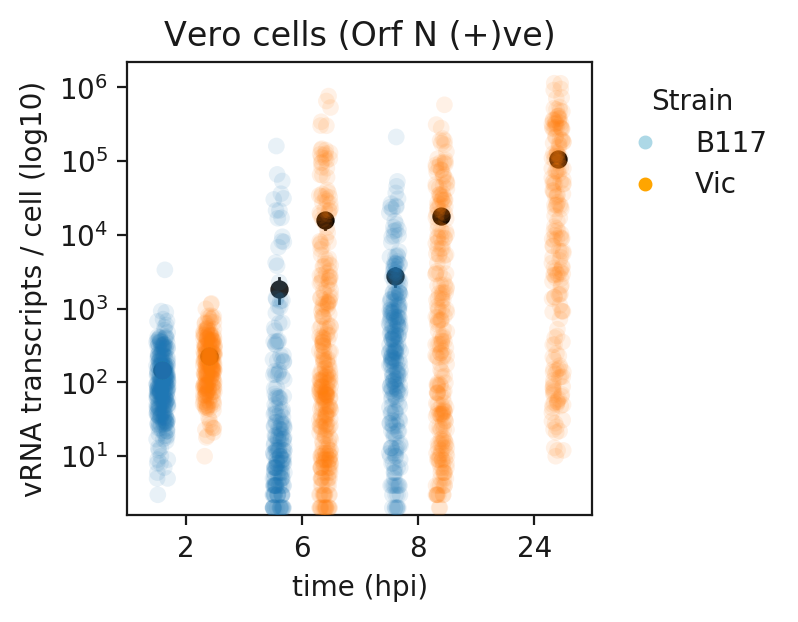

In [426]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []
time = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and row['ch'] == 3:
        #INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (Orf N (+)ve)')

# Effect of RDV on B117 growth (Orf N (+)ve)

Text(0.5,1,'Vero cells (Orf N (+)ve)')

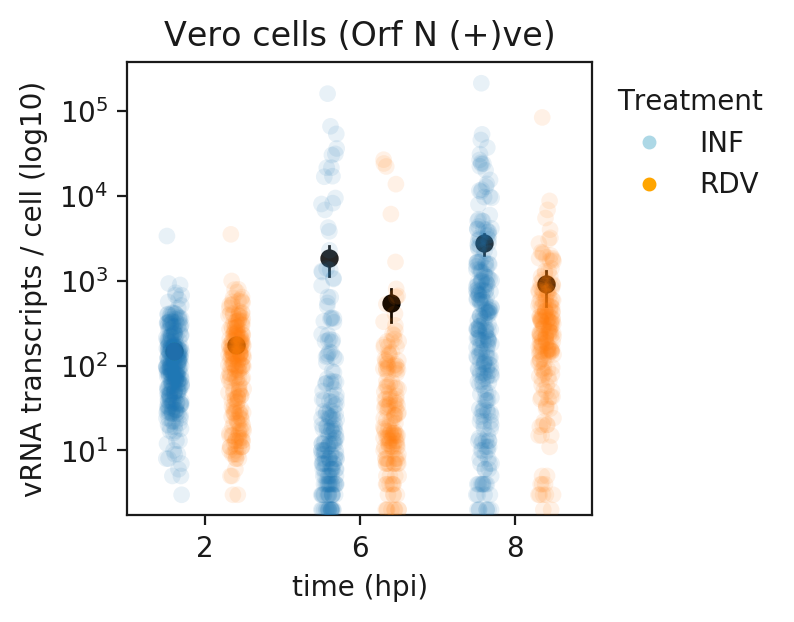

In [448]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 3 and row['treatment'] != 'MOCK' and row['strain'] == 'B117':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (Orf N (+)ve)')

# Effect of RDV on B117 growth (gRNA (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

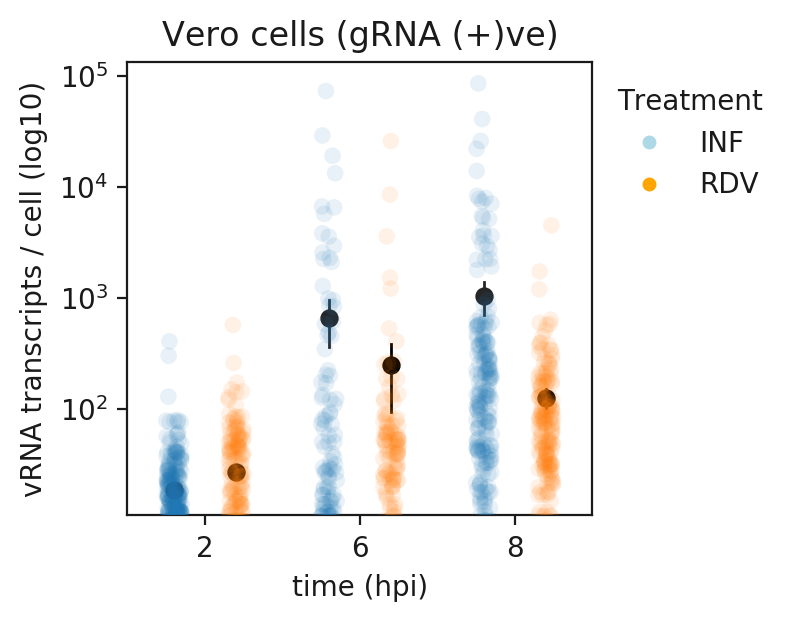

In [428]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 4 and row['treatment'] != 'MOCK' and row['strain'] == 'B117':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Effect of RDV on Vic growth (gRNA (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

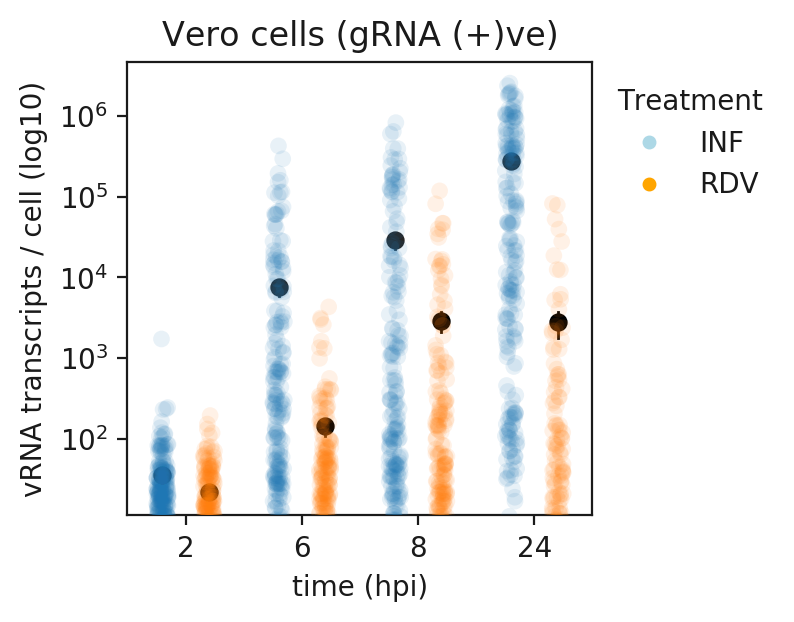

In [429]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 4 and row['treatment'] != 'MOCK' and row['strain'] == 'Vic':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Effect of RDV on Vic growth (Orf N (+)ve)

Text(0.5,1,'Vero cells (Orf N (+)ve)')

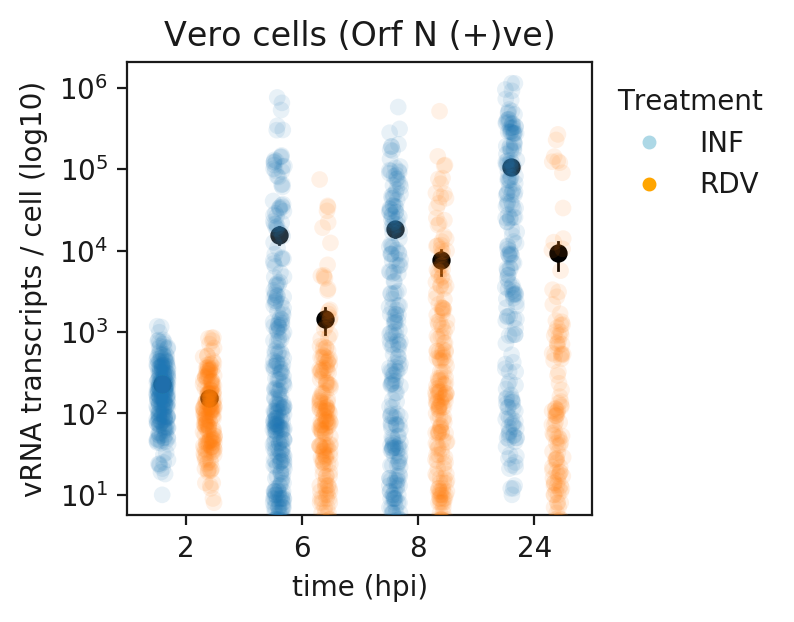

In [446]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 3 and row['treatment'] != 'MOCK' and row['strain'] == 'Vic':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (Orf N (+)ve)')

# Autothresold below this cell

# Infection timecourse by strain (gRNA (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

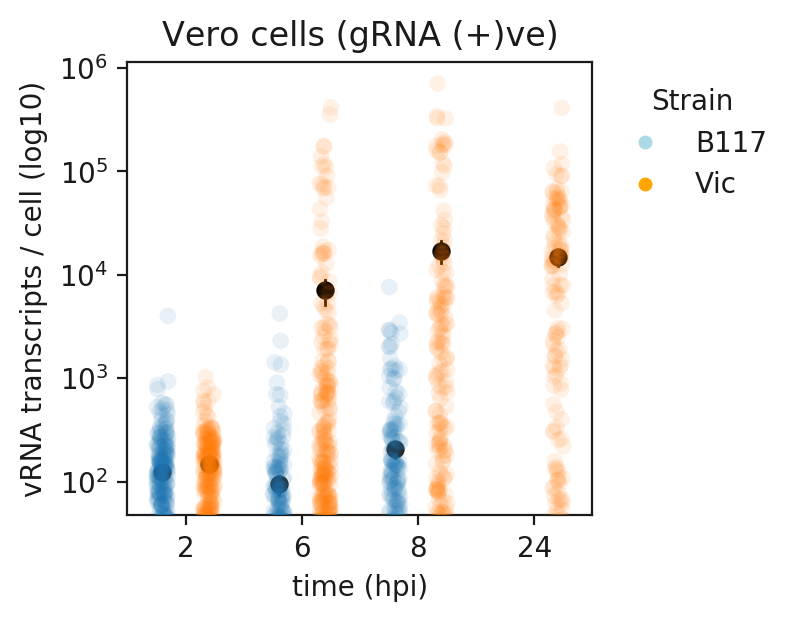

In [439]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []
time = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and  row['ch'] == 4:
        #INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Infection timecourse by strain (Orf N (+)ve)

Text(0.5,1,'Vero cells (Orf N (+)ve)')

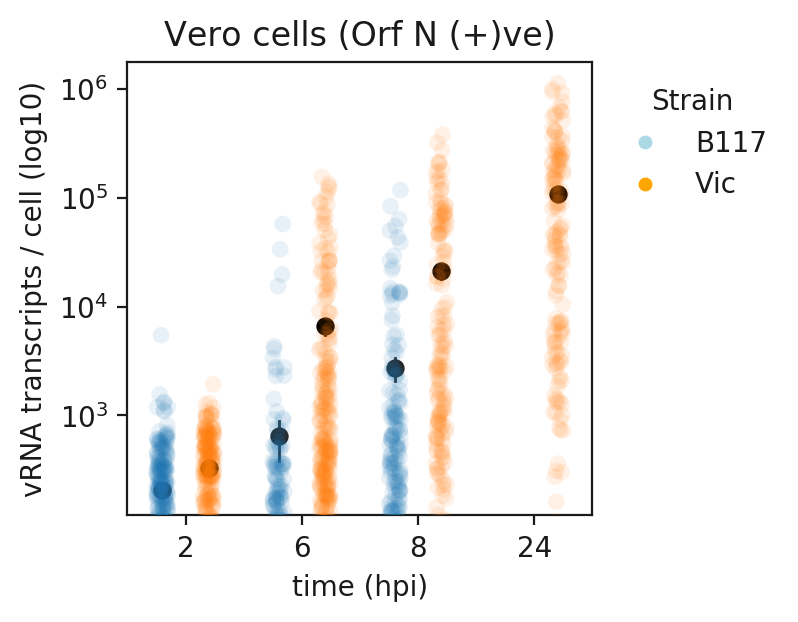

In [440]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
INF_total_vRNAs = []
INF_strain = []
INF_channel = []
time = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and row['ch'] == 3:
        #INF_channel.append(row['ch'])
        INF_strain.append(row['strain'])
        INF_total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = INF_total_vRNAs, size = 6,hue = INF_strain, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (Orf N (+)ve)')

# Effect of RDV on B117 growth (Orf N (+)ve)

Text(0.5,1,'Vero cells (Orf N (+)ve)')

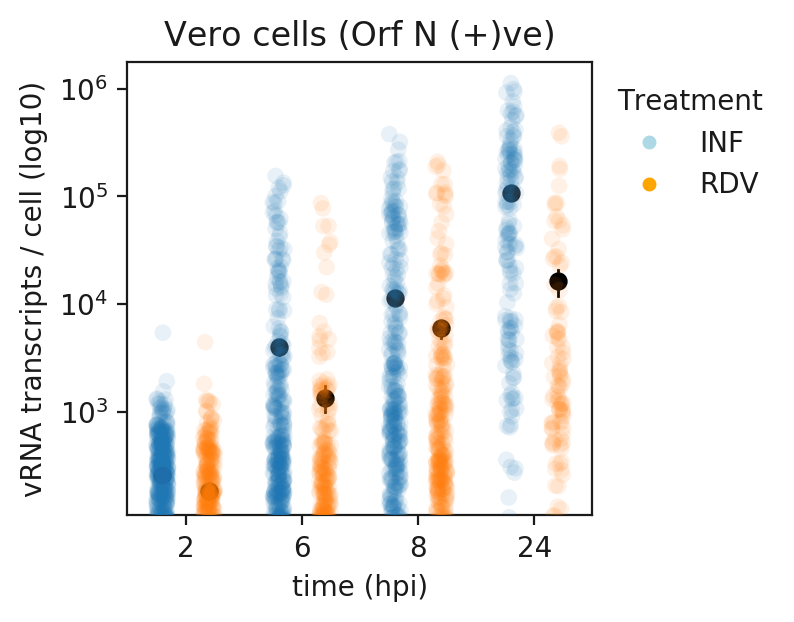

In [442]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 3 and row['treatment'] != 'MOCK':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (Orf N (+)ve)')

# Effect of RDV on B117 growth (gRNA (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

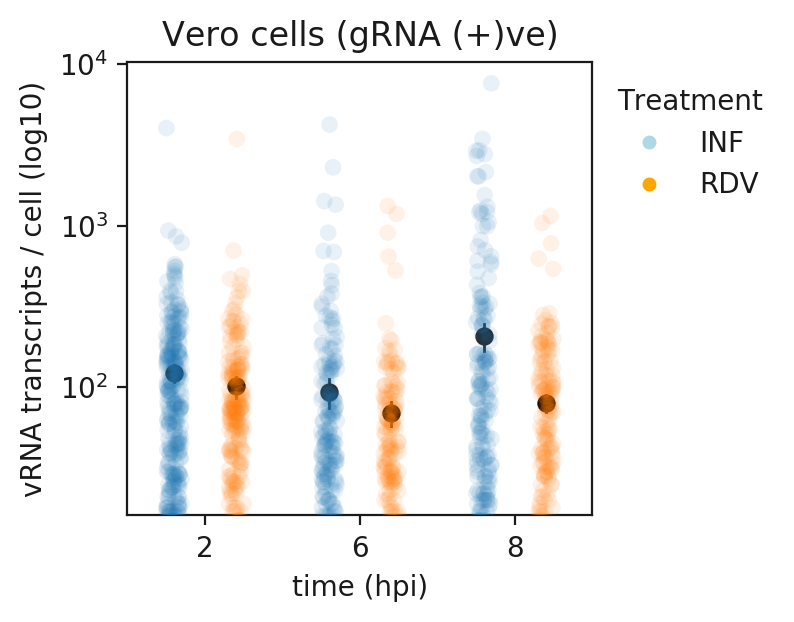

In [443]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 4 and row['treatment'] != 'MOCK' and row['strain'] == 'B117':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Effect of RDV on Vic growth (gRNA (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

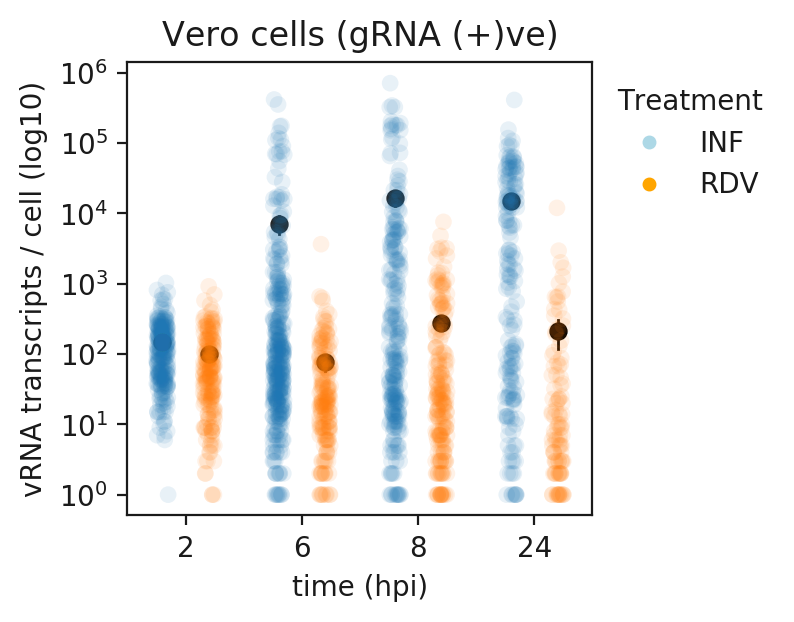

In [444]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 4 and row['treatment'] != 'MOCK' and row['strain'] == 'Vic':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Effect of RDV on Vic growth (Orf N (+)ve)

Text(0.5,1,'Vero cells (gRNA (+)ve)')

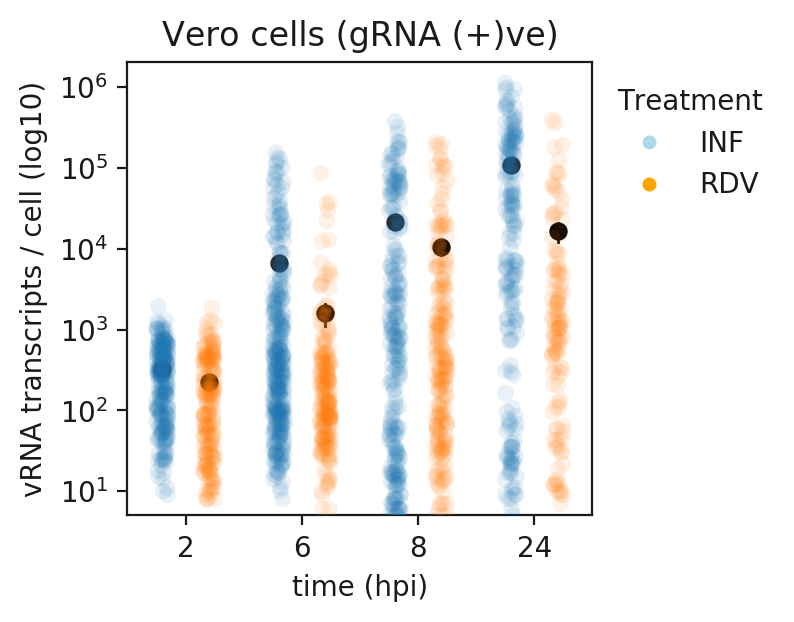

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_autothreshold.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
total_vRNAs = []
strain = []
channel = []
treatment = []
time = []

for index, row in data_tall.iterrows():
    if row['ch'] == 3 and row['treatment'] != 'MOCK' and row['strain'] == 'Vic':
        #INF_channel.append(row['ch'])
        treatment.append(row['treatment'])
        strain.append(row['strain'])
        total_vRNAs.append(row['total_vRNAs'])
        time.append(row['time'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='INF')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='RDV')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.stripplot(x = time, y = total_vRNAs, size = 6,hue = treatment,
                  dodge = True, alpha = 0.1)
ax2 = sns.pointplot(x = time, y = total_vRNAs, size = 6,hue = treatment, ci = 68, 
                 dodge = .4, scale = .75, color = 'black', join = False, errwidth = 1)

#plt.ylim(0,18)
plt.ylabel('vRNA transcripts / cell (log10)')
plt.xlabel('time (hpi)')
plt.yscale('log')
plt.minorticks_off()
plt.legend(title = 'Treatment', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

plt.title('Vero cells (gRNA (+)ve)')

# Matching Jeff's plot

# 2hpi untreated

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


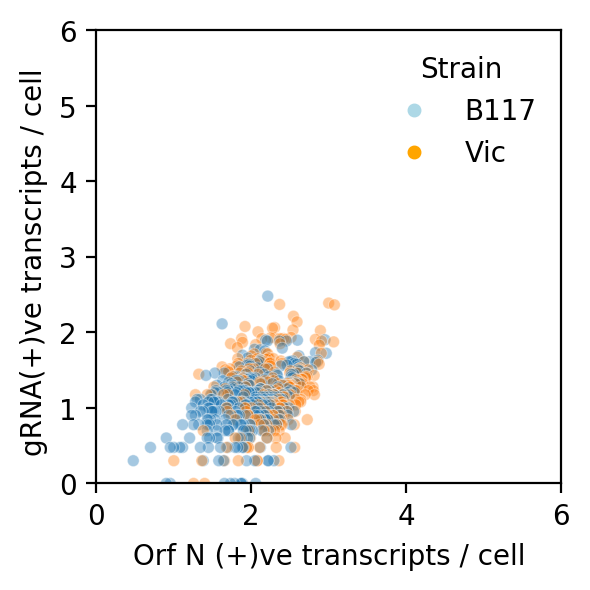

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and row['time'] == 2:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)

#plt.ylim(0,18)
plt.xlim(0,6)
plt.ylim(0,6)
plt.ylabel('gRNA(+)ve transcripts / cell ')
plt.xlabel('Orf N (+)ve transcripts / cell')

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 6 hpi untreated

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


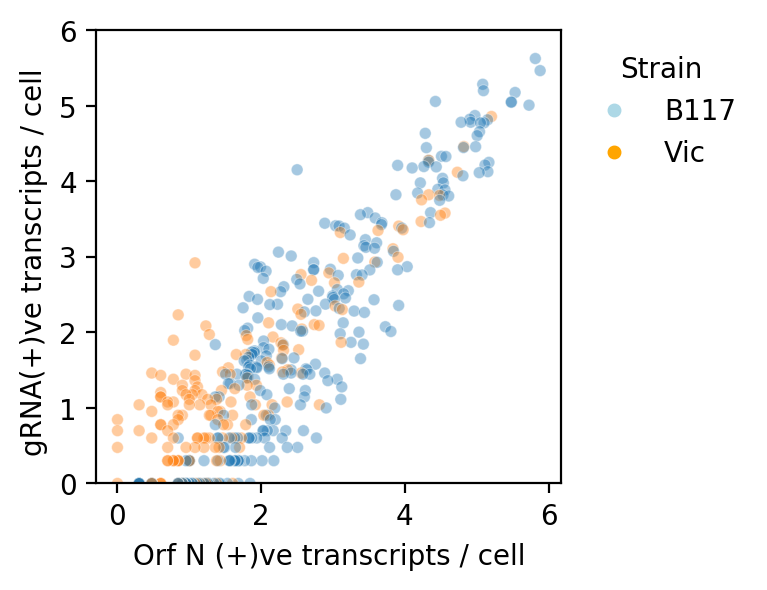

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and row['time'] == 6:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)

plt.ylim(0,6)
plt.ylabel('gRNA(+)ve transcripts / cell ')
plt.xlabel('Orf N (+)ve transcripts / cell')

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 8 hpi untreated

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


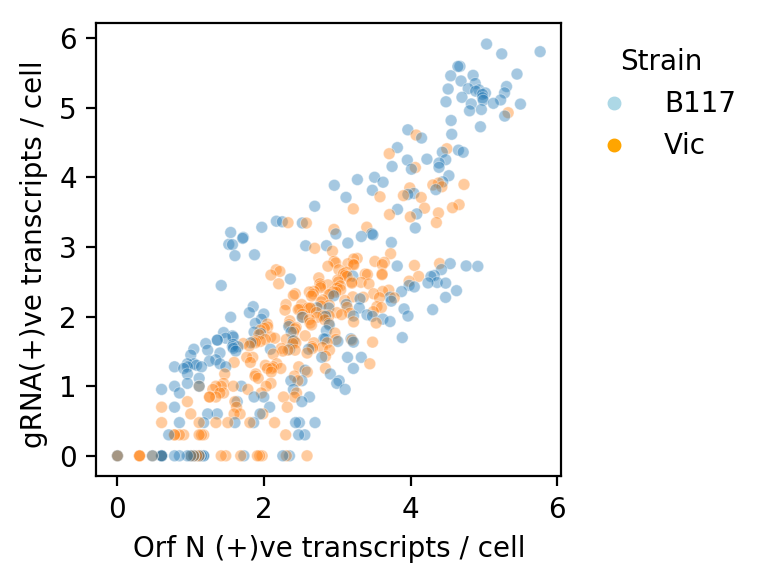

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd
import numpy as np

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and row['time'] == 8:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)



plt.ylabel('gRNA(+)ve transcripts / cell ')
plt.xlabel('Orf N (+)ve transcripts / cell')

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 24 hpi untreated

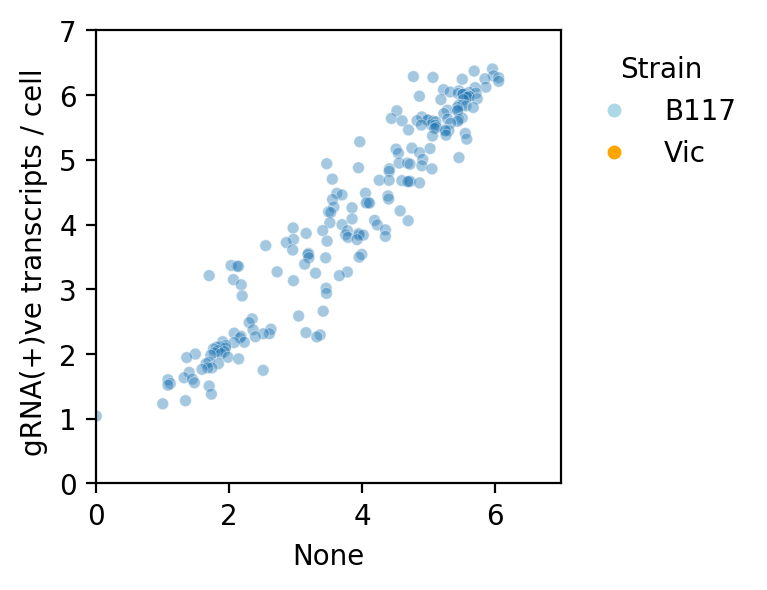

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "INF" and row['time'] == 24:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)

plt.ylim(0,7)
plt.xlim(0,7)
plt.ylabel('gRNA(+)ve transcripts / cell ')
#plt.xlabel('Orf N (+)ve transcripts / cell')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 2hpi RDV

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


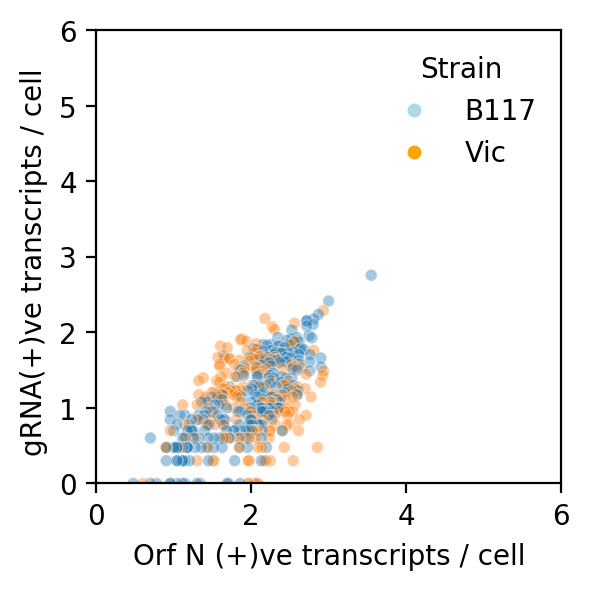

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "RDV" and row['time'] == 2:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)

#plt.ylim(0,18)
plt.xlim(0,6)
plt.ylim(0,6)
plt.ylabel('gRNA(+)ve transcripts / cell ')
plt.xlabel('Orf N (+)ve transcripts / cell')

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 6 hpi RDV

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


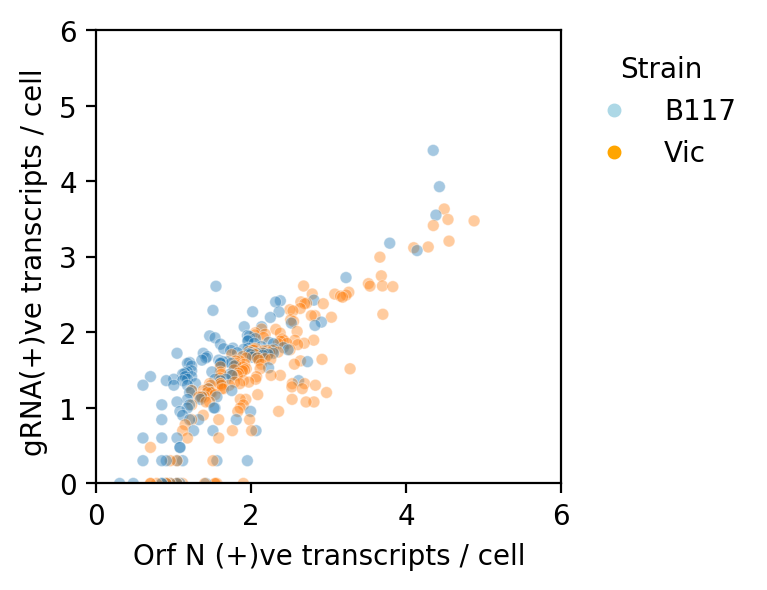

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "RDV" and row['time'] == 6:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)

plt.ylim(0,6)
plt.xlim(0,6)
plt.ylabel('gRNA(+)ve transcripts / cell ')
plt.xlabel('Orf N (+)ve transcripts / cell')

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 8 hpi RDV

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


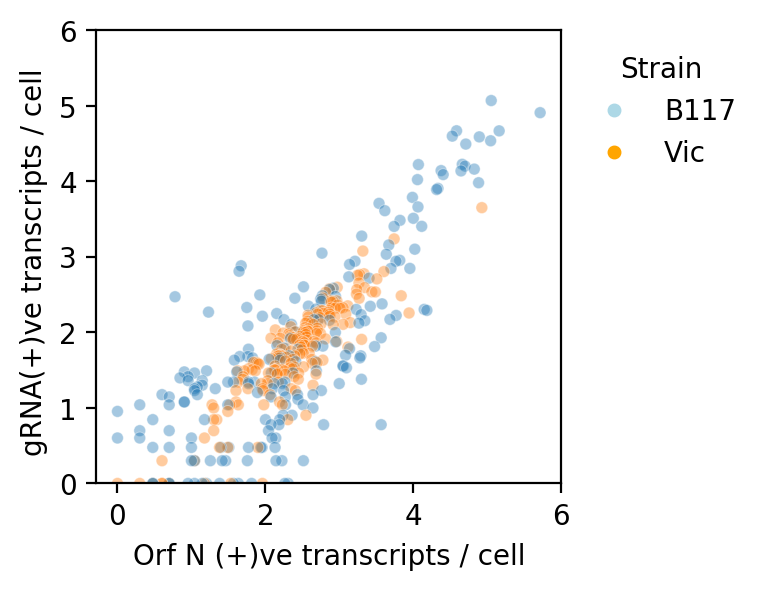

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd
import numpy as np

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "RDV" and row['time'] == 8:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)


plt.ylim(0,6)
plt.ylabel('gRNA(+)ve transcripts / cell ')
plt.xlabel('Orf N (+)ve transcripts / cell')

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')


# 24 hpi

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


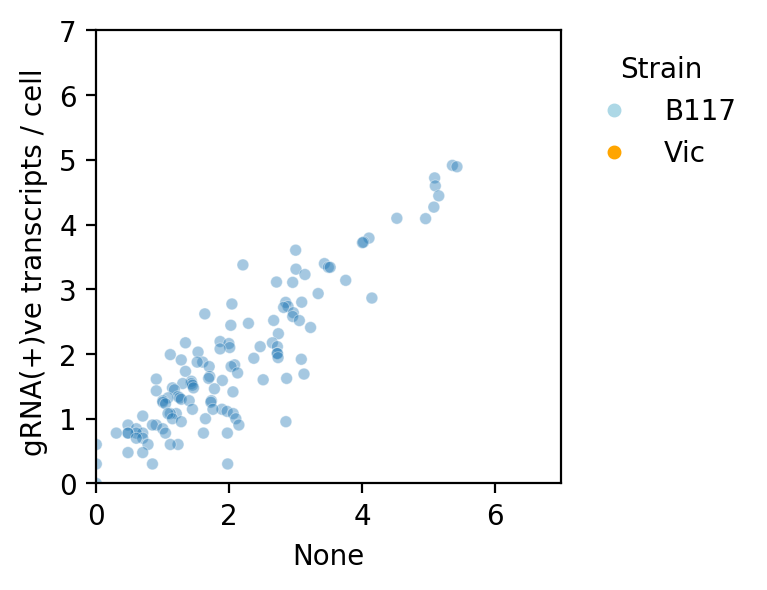

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean, median
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import pandas as pd

infile = '/Volumes/GoogleDrive/My Drive/Davis_Lab/COVID/Analysis_of_Jeffs_smFISH_data/CoV-FISH-10_B117_TIF_RAW/Data_summary_threshold_150.csv'
data_tall = pd.read_csv(infile, sep=",", header=0)

# get some buckets
ch3_total_vRNAs = []
ch4_total_vRNAs = []
strain = []

for index, row in data_tall.iterrows():
    if row['treatment'] == "RDV" and row['time'] == 24:
        ch3_total_vRNAs.append(row['ch3_total_vRNAs'])
        ch4_total_vRNAs.append(row['ch4_total_vRNAs'])
        strain.append(row['strain'])

# until I figure out how to work with ax.legend properly
blue_line = mlines.Line2D([], [], color='lightblue', marker='o',linestyle ='None', 
                          markersize=4, label='B117')

orange_line = mlines.Line2D([], [], color='orange', marker='o',linestyle ='None', 
                          markersize=4, label='Vic')

plt.figure(figsize=(3, 3), dpi=200)
ax1 = sns.scatterplot(x = np.log10(ch3_total_vRNAs), y = np.log10(ch4_total_vRNAs), hue = strain, size = 10,
                alpha = 0.4)

plt.ylim(0,7)
plt.xlim(0,7)
plt.ylabel('gRNA(+)ve transcripts / cell ')
#plt.xlabel('Orf N (+)ve transcripts / cell')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.minorticks_off()
plt.legend(title = 'Strain', handles=[blue_line, orange_line], frameon = False, bbox_to_anchor=(1, 1))

#plt.title('Vero cells (Orf N (+)ve)')
